In [1]:
import numpy as np
import pandas as pd
from scipy.linalg import lstsq
from scipy.interpolate import interp1d, LinearNDInterpolator, NearestNDInterpolator
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import xgboost as xgb 
from sklearn.model_selection import train_test_split as tts

import lightgbm as lgbm
import time


In [2]:
#Tricubic Kernel, Lowess, and general Boosting definitions

def Tricubic(x):
  if len(x.shape) == 1:
    x = x.reshape(-1,1)
  d = np.sqrt(np.sum(x**2,axis=1))
  return np.where(d>1,0,70/81*(1-d**3)**3)

def lw_reg(X, y, xnew, kern, tau, intercept):
    # tau is called bandwidth K((x-x[i])/(2*tau))
    n = len(X) # the number of observations
    yest = np.zeros(n)

    if len(y.shape)==1: # here we make column vectors
      y = y.reshape(-1,1)
    if len(X.shape)==1:
      X = X.reshape(-1,1)
    if intercept:
      X1 = np.column_stack([np.ones((len(X),1)),X])
    else:
      X1 = X

    w = np.array([kern((X - X[i])/(2*tau)) for i in range(n)]) # here we compute n vectors of weights

    #Looping through all X-points, solving for the predictions as linear combinations of inputs and weights matrix
    for i in range(n):          
        W = np.diag(w[:,i])
        b = np.transpose(X1).dot(W).dot(y)
        A = np.transpose(X1).dot(W).dot(X1)
        #A = A + 0.001*np.eye(X1.shape[1]) # if we want L2 regularization
        #theta = linalg.solve(A, b) # A*theta = b
        beta, res, rnk, s = lstsq(A, b)
        yest[i] = np.dot(X1[i],beta)
    if X.shape[1]==1:
      f = interp1d(X.flatten(),yest,fill_value='extrapolate')
    else:
      f = LinearNDInterpolator(X, yest)
    output = f(xnew) # the output may have NaN's where the data points from xnew are outside the convex hull of X
    if sum(np.isnan(output))>0:
      g = NearestNDInterpolator(X,y.ravel()) 
      # output[np.isnan(output)] = g(X[np.isnan(output)])
      output[np.isnan(output)] = g(xnew[np.isnan(output)])
    return output  

def rep_boosted_lwr(X, y, xtest, kern, tau, booster, nboost, intercept):
  yhat = lw_reg(X,y,X,kern,tau,intercept) #get loess predictions on training data
  yhat_test = lw_reg(X,y,xtest,kern,tau,intercept) #get loess predictions on testing data
  lw_error = y - yhat #find the loess training residuals; these are what the booster will train on
  #Below, fit the booster on train data and residuals, then add its predictions to the train/test predictions, then get new residuals
  for i in range(nboost): 
    booster.fit(X, lw_error)
    yhat += booster.predict(X)
    yhat_test += booster.predict(xtest)
    lw_error = y - yhat
  return yhat_test

def n_boost(X, y, xtest, model, nboost, booster, kern = None, tau = None, tau_b = None, 
            intercept = None, n_estimators=None , max_depth=None, model_nn = None):
  if booster == 'LWR':
    if model == 'LWR':
      yhat = lw_reg(X,y,X,kern,tau,intercept) #get loess predictions on training data
      yhat_test = lw_reg(X,y,xtest,kern,tau,intercept) #get loess predictions on testing data
      lw_error = y - yhat #find the loess training residuals; these are what the booster will train on
      for i in range(nboost): 
        yhat += lw_reg(X,lw_error,X,kern,tau_b,intercept)
        yhat_test += lw_reg(X,lw_error,xtest,kern,tau_b,intercept)
        lw_error = y - yhat
      return yhat_test

    if model == 'RF' or model == 'RFR':
      model_rf = RandomForestRegressor(n_estimators=n_estimators,max_depth=max_depth)
      model_rf.fit(X,y)
      yhat_rf = model_rf.predict(X)
      yhat_test = model_rf.predict(xtest)
      rf_error = y - yhat_rf
      for i in range(nboost): 
        yhat_rf += lw_reg(X,rf_error,X,kern,tau_b,intercept)
        yhat_test += lw_reg(X,rf_error,xtest,kern,tau_b,intercept)
        rf_error = y - yhat_rf
      return yhat_test

    if model == 'NN':
      model_nn.fit(X,y,validation_split=0.3, epochs=100, batch_size=20, verbose=0, callbacks=[es])
      yhat_nn = model_nn.predict(X)
      yhat_test = model_nn.predict(xtest)
      nn_error = y - yhat_nn
      for i in range(nboost): 
        yhat_nn += lw_reg(X,nn_error,X,kern,tau_b,intercept)
        yhat_test += lw_reg(X,nn_error,xtest,kern,tau_b,intercept)
        nn_error = y-yhat_nn
      return yhat_test

  else:
    if model == 'LWR':
      yhat = lw_reg(X,y,X,kern,tau,intercept) #get loess predictions on training data
      yhat_test = lw_reg(X,y,xtest,kern,tau,intercept) #get loess predictions on testing data
      lw_error = y - yhat #find the loess training residuals; these are what the booster will train on
      for i in range(nboost): 
        booster.fit(X, lw_error)
        yhat += booster.predict(X)
        yhat_test += booster.predict(xtest)
        lw_error = y - yhat
      return yhat_test

    if model == 'RF' or model == 'RFR':
      model_rf = RandomForestRegressor(n_estimators=n_estimators,max_depth=max_depth)
      model_rf.fit(X,y)
      yhat_rf = model_rf.predict(X)
      yhat_test = model_rf.predict(xtest)
      rf_error = y - yhat_rf
      for i in range(nboost): 
        booster.fit(X, rf_error)
        yhat_rf += booster.predict(X)
        yhat_test += booster.predict(xtest)
        rf_error = y - yhat_rf
      return yhat_test

    if model == 'NN':
      model_nn.fit(X,y,validation_split=0.3, epochs=100, batch_size=20, verbose=0, callbacks=[es])
      yhat_nn = model_nn.predict(X)
      yhat_test = model_nn.predict(xtest)
      nn_error = y - yhat_nn
      for i in range(nboost): 
        booster.fit(X, nn_error)
        yhat_nn += booster.predict(X)
        yhat_test += booster.predict(xtest)
        nn_error = y - yhat_nn
      return yhat_test

In [3]:
'''
#Neural Network and XGB Architectures
model_nn = Sequential() #Making a tensorflow sequential network
model_nn.add(Dense(128, activation="relu", input_dim=6))
model_nn.add(Dropout(0.1))
model_nn.add(Dense(64, activation="relu"))
model_nn.add(Dropout(0.1))
model_nn.add(Dense(1, activation="linear"))
model_nn.compile(loss='mean_squared_error', optimizer=Adam(learning_rate= 0.001, decay = 0.0001))
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=600)

booster_nn = Sequential()
booster_nn.add(Dense(32, activation="relu", input_dim=6))
booster_nn.add(Dropout(0.2))
booster_nn.add(Dense(16, activation="relu"))
booster_nn.add(Dropout(0.2))
booster_nn.add(Dense(1, activation="linear"))
booster_nn.compile(loss='mean_squared_error', optimizer=Adam(learning_rate= 0.001, decay = 0.0001))
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=600)

model_xgb = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=100,reg_lambda=20,alpha=1,gamma=10,max_depth=3)
'''


'\n#Neural Network and XGB Architectures\nmodel_nn = Sequential() #Making a tensorflow sequential network\nmodel_nn.add(Dense(128, activation="relu", input_dim=6))\nmodel_nn.add(Dropout(0.1))\nmodel_nn.add(Dense(64, activation="relu"))\nmodel_nn.add(Dropout(0.1))\nmodel_nn.add(Dense(1, activation="linear"))\nmodel_nn.compile(loss=\'mean_squared_error\', optimizer=Adam(learning_rate= 0.001, decay = 0.0001))\nes = EarlyStopping(monitor=\'val_loss\', mode=\'min\', verbose=1, patience=600)\n\nbooster_nn = Sequential()\nbooster_nn.add(Dense(32, activation="relu", input_dim=6))\nbooster_nn.add(Dropout(0.2))\nbooster_nn.add(Dense(16, activation="relu"))\nbooster_nn.add(Dropout(0.2))\nbooster_nn.add(Dense(1, activation="linear"))\nbooster_nn.compile(loss=\'mean_squared_error\', optimizer=Adam(learning_rate= 0.001, decay = 0.0001))\nes = EarlyStopping(monitor=\'val_loss\', mode=\'min\', verbose=1, patience=600)\n\nmodel_xgb = xgb.XGBRegressor(objective =\'reg:squarederror\',n_estimators=100,reg

In [4]:
data = pd.read_csv("Data/Concrete_Data.csv")
data = np.concatenate([data[data.columns[0:6]].values, data[data.columns[-1]].values.reshape(-1,1)], axis=1)
data.shape

(1030, 7)

In [18]:
#Cross-Validation
mse_lwr_d = []
mse_lwr_rf = []
mse_rf_d = []
mse_lwr_lwr = []
mse_lgbm = []

scale = StandardScaler()
for i in range(12345,12347):
  print('Random State: ' + str(i))
  kf = KFold(n_splits=5,shuffle=True,random_state=i)
  # this is the random state cross-validation loop to make sure our results are real, not just the state being good/bad for a particular model
  j = 0
  for idxtrain, idxtest in kf.split(data[:,:2]):
    t = time.time()
    j += 1
    #Split the train and test data
    xtrain = data[:,:6][idxtrain]
    ytrain = data[:,-1][idxtrain]
    ytest = data[:,-1][idxtest]
    xtest = data[:,:6][idxtest]
    xtrain = scale.fit_transform(xtrain)
    xtest = scale.transform(xtest)


    #LWR boosted with decision tree
    booster = DecisionTreeRegressor(max_depth=2)
    yhat_lwr_d = n_boost(xtrain, ytrain, xtest, model = 'LWR', nboost=3, booster=booster, 
                   kern = Tricubic, tau = 1.2, intercept = True,)
    
    #LWR boosted with RF
    booster = RandomForestRegressor(n_estimators=25, max_depth=2)
    yhat_lwr_rf = n_boost(xtrain, ytrain, xtest, model = 'LWR', nboost=3, booster=booster, 
                   kern = Tricubic, tau = 1.2, intercept = True)

    #LWR boosted with LWR
    booster='LWR'
    yhat_lwr_lwr = n_boost(xtrain, ytrain, xtest, model = 'LWR', nboost=3, booster=booster, 
                   kern = Tricubic, tau = 1.2, tau_b=0.5, intercept = True)
    
    #RF boosted with decision tree
    booster = DecisionTreeRegressor(max_depth=2)
    yhat_rf_d = n_boost(xtrain, ytrain, xtest, model = 'RFR', nboost=3, booster=booster, n_estimators=100 , max_depth=3)
    
    #RF boosted with LWR
    booster = 'LWR'
    yhat_rf_d = n_boost(xtrain, ytrain, xtest, model = 'RFR', nboost=3, booster=booster, 
                   kern = Tricubic, tau = 1.2, tau_b=0.5, intercept = True, n_estimators=100 , max_depth=3)

    #LightGBM
    lgb = lgbm.LGBMRegressor(num_iterations=1000)
    lgb.fit(xtrain, ytrain, eval_set=[(xtest, ytest)], eval_metric='mse', early_stopping_rounds=100)
    yhat_lgbm = lgb.predict(xtest, num_iteration=lgb.best_iteration_)


    #Append each model's MSE
    mse_lwr_lwr.append(mse(ytest,yhat_lwr_lwr))
    mse_lwr_d.append(mse(ytest,yhat_lwr_d))
    mse_lwr_rf.append(mse(ytest,yhat_lwr_rf))
    mse_rf_d.append(mse(ytest,yhat_rf_d))
    mse_lgbm.append(mse(ytest,yhat_lgbm))

    dt = time.time() - t
    print(str(np.around(dt/60, 2)) + 'Minutes in Split Number: ' + str(j))
    

print('\n The Results for the Concrete Compressive Strength Dataset were:')
print('The Cross-validated Mean Squared Error for LWR with Decision Tree is : '+str(np.mean(mse_lwr_d)))
print('The Cross-validated Mean Squared Error for LWR with Random Forest is : '+str(np.mean(mse_lwr_rf)))
print('The Cross-validated Mean Squared Error for Random Forest with Decision Tree is : '+str(np.mean(mse_rf_d)))
print('The Cross-validated Mean Squared Error for LWR with LWR : '+str(np.mean(mse_lwr_lwr)))
print('The Cross-validated Mean Squared Error for LightGBM : '+str(np.mean(mse_lgbm)))



Random State: 12345


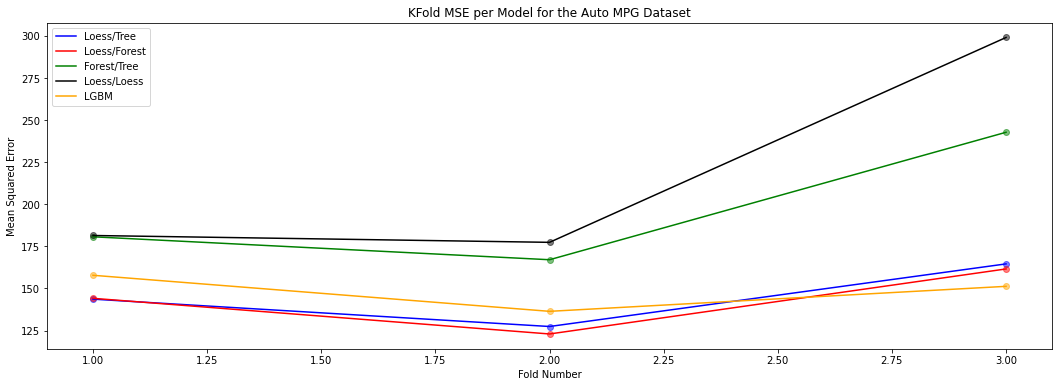

In [ ]:
fig, ax = plt.subplots(figsize=(18,6))

#Cars Plot
ax.plot(np.arange(1,4,1),mse_lwr_d, color='blue', label='Loess/Tree')
ax.plot(np.arange(1,4,1),mse_lwr_rf, color='red', label='Loess/Forest')
ax.plot(np.arange(1,4,1),mse_rf_d, color='green', label='Forest/Tree')
ax.plot(np.arange(1,4,1),mse_lwr_lwr, color='black', label='Loess/Loess')
ax.plot(np.arange(1,4,1),mse_lgbm, color='orange', label='LGBM')

ax.scatter(np.arange(1,4,1),mse_lwr_d, color='blue', alpha=0.5)
ax.scatter(np.arange(1,4,1),mse_lwr_rf, color='red', alpha=0.5)
ax.scatter(np.arange(1,4,1),mse_rf_d, color='green', alpha=0.5)
ax.scatter(np.arange(1,4,1),mse_lwr_lwr, color='black', alpha=0.5)
ax.scatter(np.arange(1,4,1),mse_lgbm, color='orange', alpha=0.5)

#ax.axhline(y=np.mean(mse_lwr_d), xmin=0, xmax = 1, color='red',label='Avg. Loess MSE', alpha=0.3)
#ax.axhline(y=np.mean(mse_lwr_rf), xmin=0, xmax=1, color='blue', label='Avg. Boosted Loess MSE', alpha=0.3)
#ax.axhline(y=np.mean(mse_rf_d), xmin=0, xmax = 1, color='green',label='Avg. Random Forest MSE', alpha=0.3)
#ax.axhline(y=np.mean(mse_lwr_lwr), xmin=0, xmax = 1, color='black',label='Avg. XGB MSE', alpha=0.3)
#ax.axhline(y=np.mean(mse_lgbm), xmin=0, xmax = 1, color='orange',label='Avg. XGB MSE', alpha=0.3)


ax.set(xlabel='Fold Number', ylabel = 'Mean Squared Error')
ax.set_title('KFold MSE per Model for the Auto MPG Dataset')
ax.legend()